In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
covid_death_data = pd.read_csv('/content/owid-covid-data.csv')
list_of_symbol = covid_death_data[~covid_death_data.location.isin(
    ['World','Asia', 'Europe', 'North America', 'South America', 'European Union', 'Africa', 'Oceanea','High income',
    'Low income','Lower middle income','Upper middle income']
)]['location'].unique()

covid_death_data['date'] = pd.to_datetime(covid_death_data['date'])
covid_death_data.set_index('location', inplace=True)
people_vaccinated =  pd.to_numeric(covid_death_data.people_fully_vaccinated	)
population =  pd.to_numeric(covid_death_data.population)
vaccination_rate = (people_vaccinated/population)*100
covid_death_data['Fully Vaccinated %'] = vaccination_rate
covid_death_data['Fully Vaccinated %'] = covid_death_data['Fully Vaccinated %'].clip(upper=100)

list_of_locations = covid_death_data.index.unique().to_list()
headers = ['location' , 'population', 'deathslastweek', 'deathssecondlastweek',
               'Fully Vaccinated %', 'RestrictionIndexlastweek', 'RestrictionIndex2ndlastweek']
pivot = pd.DataFrame(columns=headers)
for tckr in list_of_locations:
    try:
        tg = covid_death_data.loc[tckr][['date', 'population', 'new_cases_per_million',
                                         'new_deaths_per_million','stringency_index',
                                         'Fully Vaccinated %']].reset_index(drop=True).set_index('date')
        rf = tg.loc[tg['Fully Vaccinated %'].first_valid_index():,:]
        
        vax = rf['Fully Vaccinated %'].fillna(method='ffill').diff().fillna(0).values
        res =  rf["stringency_index"].fillna(method='ffill').values
        deaths = rf["new_deaths_per_million"].fillna(0).values
        #yf = pd.Series(sm.tsa.stattools.ccf(vax, deaths, adjusted=False))
        #yr = pd.Series(sm.tsa.stattools.ccf(res, deaths, adjusted=False))
        #print(np.mean(yf[:14]), np.mean(yr[:14]))
        pop = tg['population'][-1]
        
        fv1 = tg.loc[tg['Fully Vaccinated %'][-40:].first_valid_index()]['Fully Vaccinated %']
        #print(tg.loc[tg['Fully Vaccinated %'][-40:].first_valid_index()]['Fully Vaccinated %'])
        fv2 = tg['Fully Vaccinated %'][-20]
        tg = tg.drop(columns=['population','Fully Vaccinated %']).resample('3W').mean().dropna()
        dic = {'location': tckr , 'population': pop, 
               'deathslastweek': tg['new_deaths_per_million'][-1],
               'deathssecondlastweek': tg['new_deaths_per_million'][-2],
               'inflastweek': tg['new_cases_per_million'][-1],
               'infsecondlastweek': tg['new_cases_per_million'][-2],
               'Fully Vaccinated %1': fv1, 'Fully Vaccinated %': fv2, 'RestrictionIndexlastweek': tg['stringency_index'][-1],
               'RestrictionIndex2ndlastweek': tg['stringency_index'][-2]
               }
    except:
        dic = {'location': tckr , 'population': np.nan, 'deathslastweek': np.nan, 
               'deathssecondlastweek': np.nan,
               'inflastweek': np.nan,
               'infsecondlastweek': np.nan,'Fully Vaccinated %1':np.nan,
               'Fully Vaccinated %': np.nan, 'RestrictionIndexlastweek': np.nan, 
               'RestrictionIndex2ndlastweek': np.nan}
    pivot = pivot.append(dic, ignore_index= True)
pivot = pivot.dropna().reset_index(drop=True).sort_values('Fully Vaccinated %',ignore_index=True)

In [ ]:
pivot = pivot.dropna().reset_index(drop=True).sort_values('Fully Vaccinated %',ignore_index=True)
pivot['CFR'] = (pivot['deathslastweek'])/pivot['inflastweek']
pivot['CFR0'] = (pivot['deathssecondlastweek'])/pivot['infsecondlastweek']
pivot['deathrate'] = (pivot['deathslastweek']-pivot['deathssecondlastweek'])/pivot['deathssecondlastweek']
pivot['infectionrate'] = (pivot['inflastweek']-pivot['infsecondlastweek'])/pivot['infsecondlastweek']
pivot['vaccrate'] = (pivot['Fully Vaccinated %']-pivot['Fully Vaccinated %1'])/pivot['Fully Vaccinated %1']
bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
pivot['Fully Vaccinated %'] = pd.cut(pivot['Fully Vaccinated %'], bins)

In [ ]:
pivot

,location,population,deathslastweek,deathssecondlastweek,Fully Vaccinated %,RestrictionIndexlastweek,RestrictionIndex2ndlastweek,Fully Vaccinated %1,inflastweek,infsecondlastweek,CFR,CFR0,deathrate,infectionrate,vaccrate
0,Democratic Republic of Congo,92377986.0,0.006750,0.004143,"(0, 10]",39.810000,39.810000,0.039716,0.335625,0.153048,0.020112,0.027069,0.629310,1.192945,0.072556
1,Chad,16914985.0,0.002810,0.000000,"(0, 10]",22.220000,22.220000,0.262950,0.106952,0.028095,0.026269,0.000000,inf,2.806780,0.376186
2,Ethiopia,117876226.0,0.074125,0.107048,"(0, 10]",43.520000,43.520000,0.794840,1.601250,2.620619,0.046292,0.040848,-0.307551,-0.388980,0.431163
3,Somalia,16359500.0,0.337619,0.081524,"(0, 10]",35.190000,35.190000,1.580922,2.826381,2.121952,0.119453,0.038419,3.141355,0.331972,0.220817
4,Djibouti,1002197.0,0.237571,0.332619,"(0, 10]",43.520000,39.548571,2.602981,1.092905,14.206905,0.217376,0.023412,-0.285755,-0.923072,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Seychelles,98910.0,3.791375,1.444333,"(70, 100]",75.000000,70.503810,75.602062,433.474750,255.643667,0.008746,0.005650,1.625000,0.695621,0.025649
88,Chile,19212362.0,1.132125,0.758381,"(70, 100]",35.650000,36.266667,74.803416,122.531750,110.653000,0.009239,0.006854,0.492818,0.107351,0.065508
89,Spain,46745211.0,0.425125,0.551095,"(70, 100]",41.200000,41.200000,79.214885,132.050875,50.347952,0.003219,0.010946,-0.228582,1.622766,0.008958
90,Malta,516100.0,0.258400,0.276857,"(70, 100]",43.520000,43.520000,82.258865,111.993600,41.612476,0.002307,0.006653,-0.066667,1.691347,0.010423


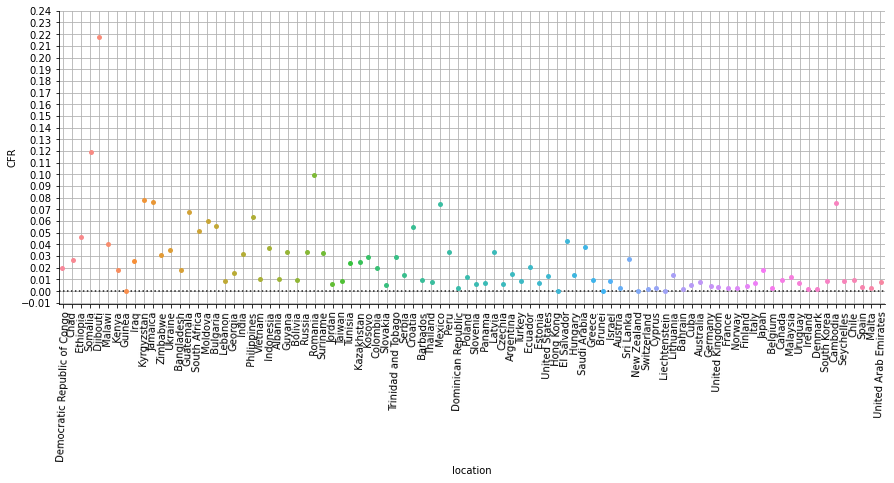

In [ ]:
g= sns.catplot(x="location", y="CFR", data=pivot, height=4.8, aspect=2.8)
#g= sns.catplot(x="location", y="CFR", hue="Fully Vaccinated %", data=pivot, height=4.8, aspect=2.8)

g.map(plt.axhline, y=0, ls=":", c=".1")

for ax in g.axes.flat:
    ax.grid(True, axis='both')
plt.xticks(rotation=88)
plt.yticks(np.arange(-0.01, 0.25, 0.01))
plt.savefig('cfr.png', dpi=400, bbox_inches='tight')